## Import Data and Libraries

In [1]:
from Functions import normalize_data, time_series_CV_split, train_and_predict, fine_tune_alpha
from pyspark import SparkContext
from spark_sklearn import GridSearchCV
from pylab import *

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import MinMaxScaler 
from time import time
from math import sqrt
from sklearn.linear_model import ElasticNet, SGDRegressor, LinearRegression, ElasticNetCV, LassoCV, Lasso, Ridge, RidgeCV, BayesianRidge, ARDRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.neighbors import KNeighborsRegressor

from matplotlib import pyplot
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

data = pd.read_csv('bitcoin_train.csv')
data = data.drop(columns=['date','low','open','high','marketcap'])
print('n_features:', len(data.iloc[0]))
print('n_samples:', len(data))
data.head()

n_features: 36
n_samples: 2735


,close,volatility,volume,google_trends,gold,silver,platinum,palladium,oil,usd_eur,...,TXN_per_block,est_TXN_vol,cost_per_TXN,total_TXN_fees,usd_trade_vol,hash_rate,avg_block_size,difficulty,num_unique_addr,miners_revenue
0,0.2989,0.037022,548.33,0.019074,1388.5,30.67,1753.0,784.0,89.39,1.3421,...,7.0,8950.0,1.714398,0.023855,789.544097,0.115112,0.002296,16307.42094,943,2129.2829
1,0.2990,0.030563,106.19,0.019074,1368.0,29.21,1722.0,754.0,90.30,1.3213,...,8.0,4746.0,1.881279,0.017457,57.813954,0.121597,0.002129,16307.42094,1064,2242.4850
2,0.2980,0.030563,1031.28,0.019074,1368.5,29.08,1731.0,766.0,88.37,1.3091,...,7.0,5052.0,2.585471,0.026185,890.419309,0.119165,0.001730,16307.42094,950,2197.6500
3,0.3200,0.079137,13152.15,0.019074,1367.0,28.39,1735.0,754.0,88.07,1.2961,...,7.0,5304.0,2.634545,0.023675,13047.281580,0.116733,0.001584,16307.42094,887,2318.4000
4,0.3229,0.044001,512.04,0.019074,1367.0,28.39,1735.0,754.0,88.07,1.2961,...,6.0,9216.0,2.226883,0.006458,1273.388302,0.155644,0.001875,16307.42094,1267,3099.8208


## Define Functions 

In [11]:
def plot_features_ranking(feature_importances, model):
    #!/usr/bin/env python
    # make a horizontal bar chart
    val = feature_importances  # the bar lengths
    pos = data.columns[1:] # the bar centers on the y axis

    figure(1,figsize=(10, 8))
    barh(pos,val, align='center')
    yticks(pos, data.columns[1:])
    xlabel('Importance')
    title(model)
    grid(True)
    
    show()

def get_feature_ranking(feature_scores):
    indices = np.nonzero(feature_scores)[0].tolist()
    scores = np.abs(feature_scores[indices]).tolist() 
    sorted_scores, sorted_features = zip(*sorted(zip(scores, indices),reverse=True))
    return list(sorted_features)

# Stop printing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


## Data Period Selection

In [12]:

# Data period
periods = [2017,2016,2015,2014,2013,2012,2011]
period_indices = [2189,1823,1458,1093,728,362,0] #[2610,2540,2470,2400,2330,2260,2189]

# Training with different data period
period_rmse = []
for index in period_indices:
    train_data = data.iloc[index:,:].values
    n_samples = len(train_data)
    Y = train_data[1:,0].reshape(-1,1)
    X = train_data[0:n_samples-1,1:]
    rmse = train_model(X,Y,Lasso(),n_validation=91,predict=False,return_y=False)
    period_rmse.append(rmse)    
# Compare test RMSE of different period
print('RMSE of different periods')
for i in range(0,len(periods)):
    print(str(periods[i])+': ',str(period_rmse[i]))
print('Best period:', str(periods[np.argmin(period_rmse)]))

# Prepare training data for all models
start = period_indices[np.argmin(period_rmse)] # use best period

train_data = data.iloc[start:,:].values
n_samples = len(train_data)
Y = train_data[1:,0].reshape(-1,1)
X = train_data[0:n_samples-1,1:]


RMSE of different periods
2017:  1462.4262635337766
2016:  489.95053080910657
2015:  493.62861395219676
2014:  687.7906832033543
2013:  909.1348890649067
2012:  1077.044371089757
2011:  1145.7259622380232
Best period: 2016


## Feature Selection

### Lasso

In [ ]:
%%time
# Fine tune alpha
best_alpha = fine_tune_alpha(X,Y,'Lasso')
lasso = Lasso(alpha=best_alpha)
lasso.fit(normalize_data(X,Y),Y.reshape(-1,))

Lasso Features Ranking: [34, 28, 30, 32, 1, 27, 2, 8, 25, 12, 22, 0, 17, 6, 18, 24, 9, 5, 31, 10, 19, 33, 23, 14]
Best Alpha: 1.0625423728813561
Best RMSE: 291.80148264094703


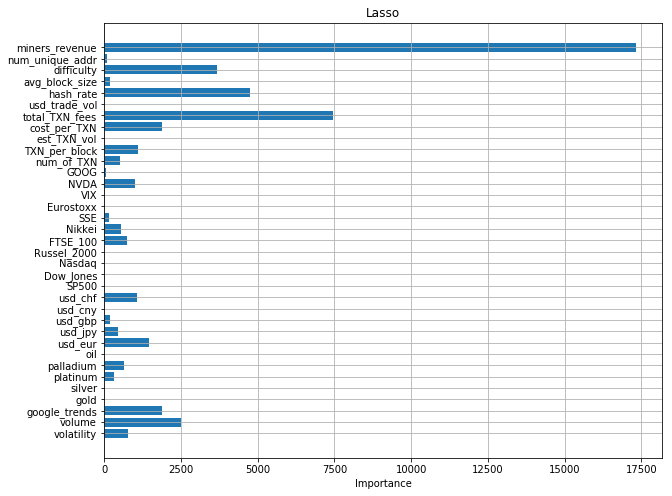

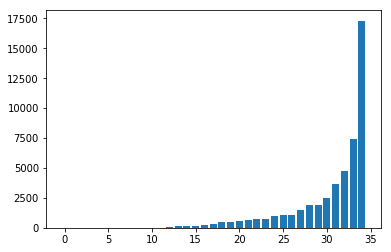

In [51]:

lasso_features = get_feature_ranking(lasso.coef_)
print('Lasso Features Ranking:',lasso_features)
print("Best Alpha:", str(best_alpha))
print("Best RMSE:", str(best_rmse))
plot_features_ranking(np.abs(lasso.coef_), 'Lasso')
# plot
pyplot.bar(range(len(lasso.coef_)), sorted(np.abs(lasso.coef_)))
pyplot.show()



### XGBoost

In [9]:
from sklearn.pipeline import Pipeline
pipe = pipe = Pipeline([
    ('normalize', MinMaxScaler()),
    ('xgb', XGBRegressor())
])
pipe

Pipeline(memory=None,
     steps=[('normalize', MinMaxScaler(copy=True, feature_range=(0, 1))), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [8]:
%%time
sc = SparkContext()

param_grid = [{
            "xgb__silent":[True],
            "xgb__learning_rate": [0.25, 0.15, 0.1, 0.2, 0.3],
            "xgb__gamma": [1,2,3],
            "xgb__max_depth": [3, 5, 10],
            "xgb__n_estimators": [105,110,115],
            "xgb__reg_alpha": [0,1],
            "xgb__n_jobs": [-1],
            "xgb__booster": ["gbtree"]
} ]

gs = GridSearchCV(sc, pipe, param_grid, cv=split, scoring=make_scorer(RMSE,greater_is_better=False), verbose=1) 
gs.fit(X,Y.reshape(-1,))
print('Best Parameters: ',gs.cv_results_['params'][gs.best_index_])
sc.stop()

Fitting 91 folds for each of 270 candidates, totalling 24570 fits
Best Parameters:  {'xgb__booster': 'gbtree', 'xgb__gamma': 2, 'xgb__learning_rate': 0.15, 'xgb__max_depth': 5, 'xgb__n_estimators': 115, 'xgb__n_jobs': -1, 'xgb__reg_alpha': 1, 'xgb__silent': True}
CPU times: user 2.54 s, sys: 600 ms, total: 3.14 s
Wall time: 1h 4min 6s


Best RMSE: -333.94709478021986
XGB Features Ranking: [0, 1, 29, 31, 27, 6, 28, 24, 25, 34, 7, 2, 8, 3, 26, 22, 4, 11, 21, 33, 20, 30, 17, 9, 13, 23, 14, 32, 15, 18, 12, 5, 10, 16, 19]


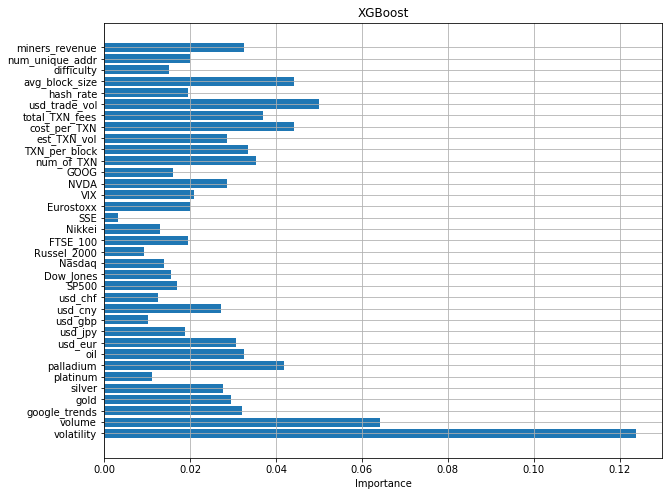

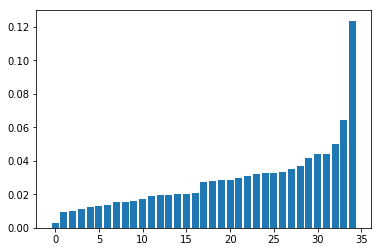

In [47]:
print("Best RMSE:", str(gs.cv_results_['mean_test_score'][gs.best_index_]))
xgb = XGBRegressor(booster='gbtree',gamma=2,learning_rate=0.15,max_depth=5,n_estimators=115,n_jobs=-1,reg_alpha=1,silent=True)
xgb.fit(X,Y.reshape(-1,))
xgb_features = get_feature_ranking(xgb.feature_importances_)
print('XGB Features Ranking:',xgb_features)
plot_features_ranking(xgb.feature_importances_, 'XGBoost')
# plot
pyplot.bar(range(len(xgb.feature_importances_)), sorted(xgb.feature_importances_))
pyplot.show()

### ExtraTrees

In [5]:
from sklearn.pipeline import Pipeline
pipe = pipe = Pipeline([
    ('normalize', MinMaxScaler()),
    ('extrees', ExtraTreesRegressor())
])
pipe

Pipeline(memory=None,
     steps=[('normalize', MinMaxScaler(copy=True, feature_range=(0, 1))), ('extrees', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [6]:
%%time
sc = SparkContext()

param_grid = [{"extrees__max_features": [10,15,18,20,22,25,30],
              "extrees__n_estimators": [40,50,60],
              "extrees__random_state": [1,100],
              "extrees__max_depth": [10,None],
              "extrees__n_jobs": [-1],
              "extrees__bootstrap": [True,False]
        }]

gs = GridSearchCV(sc, pipe, param_grid, cv=split, scoring=make_scorer(RMSE,greater_is_better=False), verbose=1) 
gs.fit(X,Y.reshape(-1,))
print('Best Parameters: ',gs.cv_results_['params'][gs.best_index_])
sc.stop()

Fitting 91 folds for each of 168 candidates, totalling 15288 fits
Best Parameters:  {'extrees__bootstrap': False, 'extrees__max_depth': None, 'extrees__max_features': 20, 'extrees__n_estimators': 50, 'extrees__n_jobs': -1, 'extrees__random_state': 1}
CPU times: user 1.93 s, sys: 517 ms, total: 2.45 s
Wall time: 25min 1s


Best RMSE: -316.6990659340661
Extra Trees Features Ranking: [34, 32, 14, 18, 27, 22, 1, 6, 23, 30, 16, 15, 19, 29, 28, 13, 26, 7, 8, 11, 2, 33, 3, 9, 5, 20, 4, 21, 10, 12, 17, 24, 0, 31, 25]


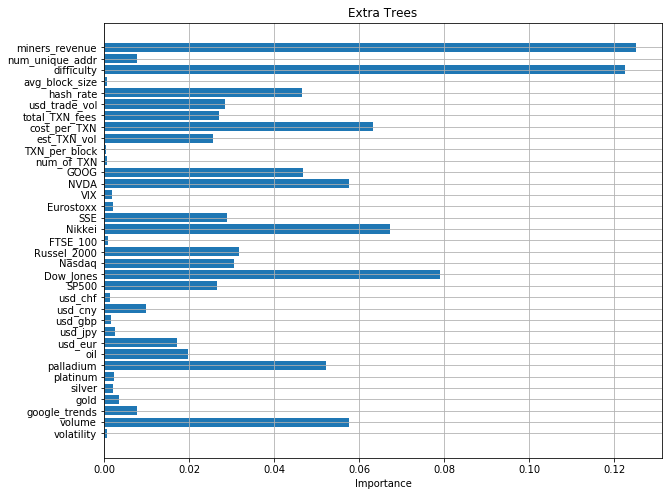

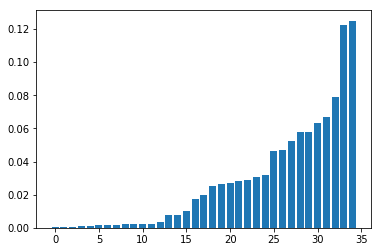

In [49]:
print("Best RMSE:", str(gs.cv_results_['mean_test_score'][gs.best_index_]))
# Fit using best parameters
etrees = ExtraTreesRegressor(bootstrap=False,max_depth=None,max_features=20,n_estimators=50,n_jobs=-1,random_state=1) 
etrees.fit(X,Y.reshape(-1,))
etrees_features = get_feature_ranking(etrees.feature_importances_)
print('Extra Trees Features Ranking:',etrees_features)
plot_features_ranking(etrees.feature_importances_, 'Extra Trees')
# plot
pyplot.bar(range(len(etrees.feature_importances_)), sorted(etrees.feature_importances_))
pyplot.show()